In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv


In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


In [7]:
import tensorflow as tf


2024-07-24 19:40:17.679863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 19:40:17.679988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 19:40:17.802884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
from tensorflow.keras.layers import Input

In [9]:

from tensorflow.keras.layers import Dense


In [10]:
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber

In [12]:

# Load dataset
file_path = "/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv"
data = pd.read_csv(file_path)


# Handle NaN values - fill with mean for numerical and mode for categorical
data.fillna(data.mean(numeric_only=True), inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)

In [13]:
# Selected features
features = ['ETL electron affinity(eV)','Rshunt (ohm cm2)','VOC(V)', 'JSC(mA/cm2)', 'FF(%)']
target = 'PCE(%)'

In [14]:
# Split data into features and target
X = data[features]
y = data[target]

# Identify categorical and numerical features
categorical_features = []
numerical_features = [col for col in features if col not in categorical_features]



In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [16]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Convert to numpy arrays
y = y.to_numpy()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [17]:
from tensorflow.keras.models import Model

def build_mlp_model(input_shape, loss_function):
    inputs = Input(shape=(input_shape,))
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_function, metrics=['mae', 'mse'])
    return model

# Define input shape
input_shape = X_train.shape[1]

# Build models with different loss functions
model_mae = build_mlp_model(input_shape, MeanAbsoluteError())
model_mse = build_mlp_model(input_shape, MeanSquaredError())
model_huber = build_mlp_model(input_shape, Huber())

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the models
history_mae = model_mae.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=64, callbacks=[early_stopping], verbose=2)
history_mse = model_mse.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=64, callbacks=[early_stopping], verbose=2)
history_huber = model_huber.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=64, callbacks=[early_stopping], verbose=2)


Epoch 1/200


I0000 00:00:1721850035.450805     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


409/409 - 12s - 30ms/step - loss: 1.0611 - mae: 1.0611 - mse: 2.8272 - val_loss: 0.2414 - val_mae: 0.2414 - val_mse: 0.2048
Epoch 2/200
409/409 - 1s - 2ms/step - loss: 0.6859 - mae: 0.6859 - mse: 0.9440 - val_loss: 0.2293 - val_mae: 0.2293 - val_mse: 0.1356
Epoch 3/200
409/409 - 1s - 2ms/step - loss: 0.6301 - mae: 0.6301 - mse: 0.7994 - val_loss: 0.3323 - val_mae: 0.3323 - val_mse: 0.3596
Epoch 4/200
409/409 - 1s - 2ms/step - loss: 0.5881 - mae: 0.5881 - mse: 0.6864 - val_loss: 0.1510 - val_mae: 0.1510 - val_mse: 0.0995
Epoch 5/200
409/409 - 1s - 2ms/step - loss: 0.5529 - mae: 0.5529 - mse: 0.6111 - val_loss: 0.1619 - val_mae: 0.1619 - val_mse: 0.1267
Epoch 6/200
409/409 - 1s - 2ms/step - loss: 0.5332 - mae: 0.5332 - mse: 0.5634 - val_loss: 0.1679 - val_mae: 0.1679 - val_mse: 0.1028
Epoch 7/200
409/409 - 1s - 2ms/step - loss: 0.5175 - mae: 0.5175 - mse: 0.5356 - val_loss: 0.1621 - val_mae: 0.1621 - val_mse: 0.0868
Epoch 8/200
409/409 - 1s - 2ms/step - loss: 0.5095 - mae: 0.5095 - mse: 

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE Model Performance:
  MAE: 0.0678
  MSE: 0.0163
  R2 Score: 0.9977
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE Model Performance:
  MAE: 0.1267
  MSE: 0.0530
  R2 Score: 0.9925
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Huber Model Performance:
  MAE: 0.0845
  MSE: 0.0176
  R2 Score: 0.9975


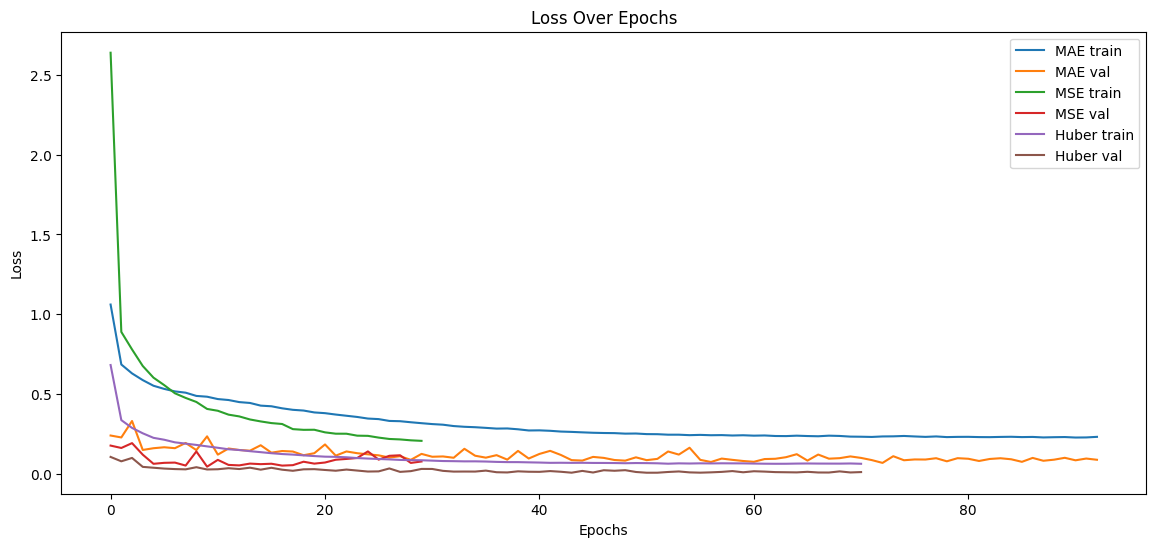

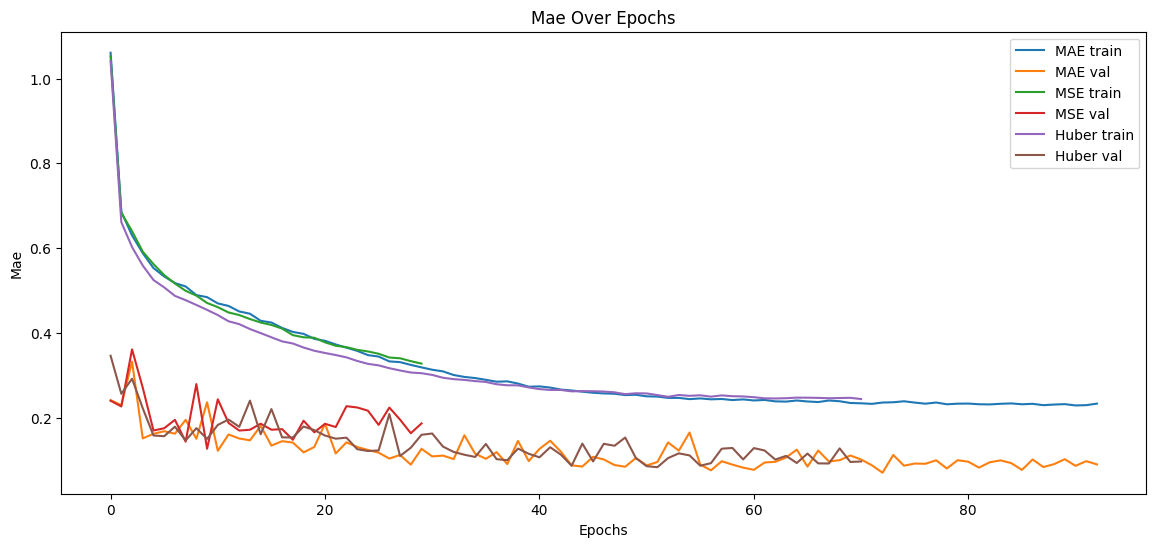

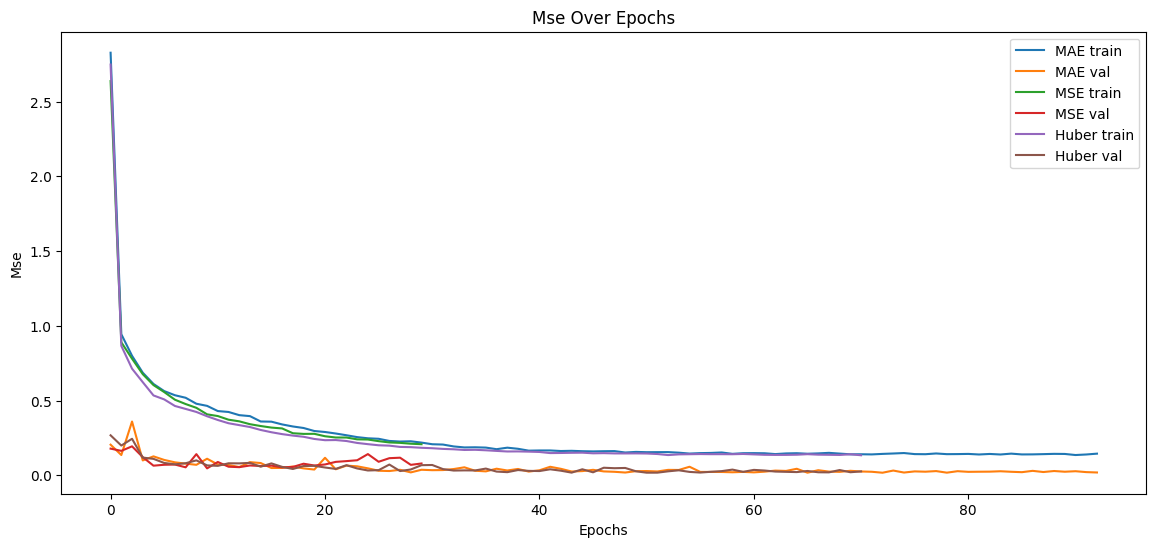

Performance of MAE Model:
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


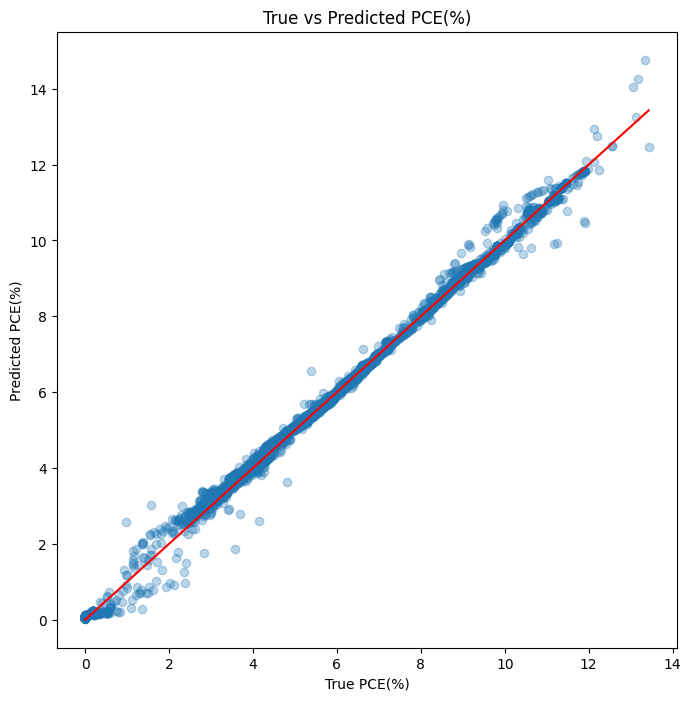

Performance of MSE Model:
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


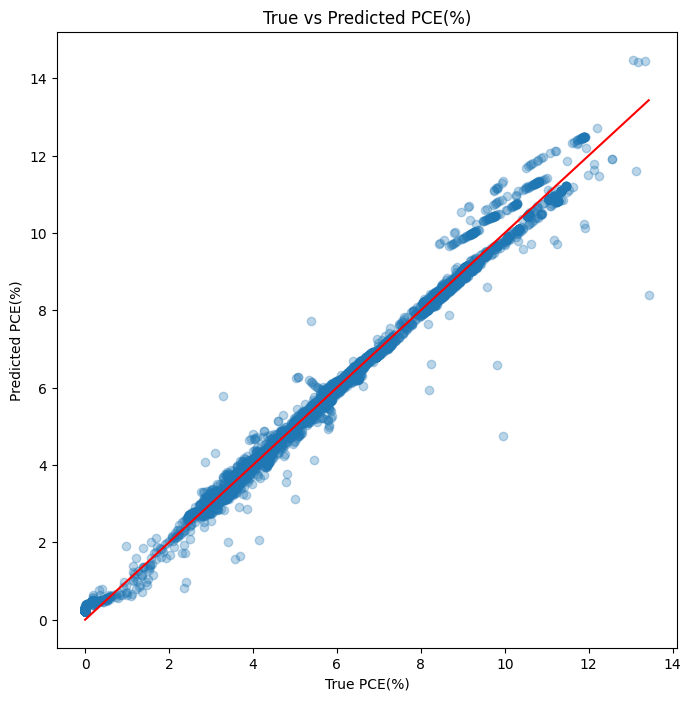

Performance of Huber Model:
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


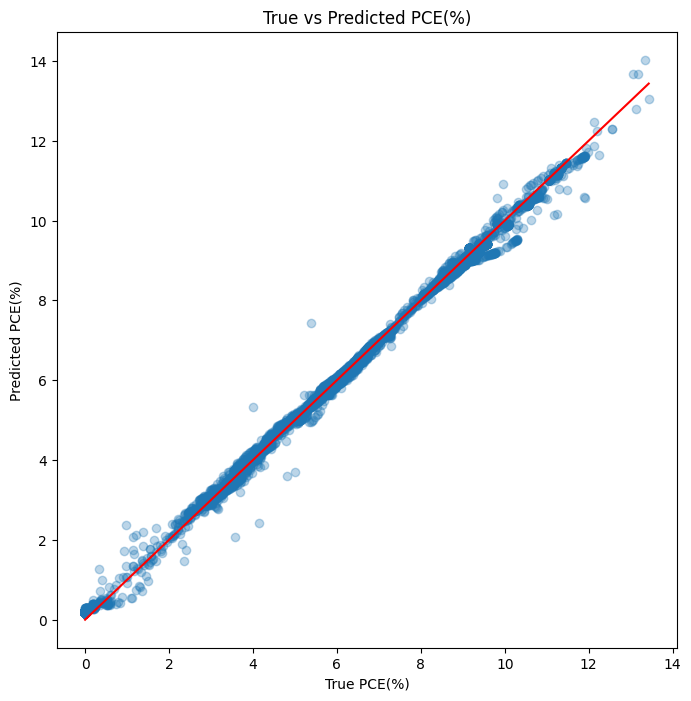

In [19]:
# Evaluate models
models = {'MAE': model_mae, 'MSE': model_mse, 'Huber': model_huber}
histories = {'MAE': history_mae, 'MSE': history_mse, 'Huber': history_huber}

# Function to evaluate and print model performance
def evaluate_models(models, X_test, y_test, label):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        accuracy = r2 * 100  # Convert R2 score to percentage
        print(f'{label} {name} Model Performance:')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  Accuracy: {accuracy:.2f}%')

# Evaluate models
evaluate_models(models, X_test, y_test, 'ANN')

# Plot training history
def plot_history(histories, key='loss', label=''):
    plt.figure(figsize=(14, 6))
    for name, history in histories.items():
        plt.plot(history.history[key], label=f'{label} {name} train')
        plt.plot(history.history[f'val_{key}'], label=f'{label} {name} val')
    plt.xlabel('Epochs')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.title(f'{key.capitalize()} Over Epochs')
    plt.show()

# Plot training history
plot_history(histories, key='loss', label='ANN')
plot_history(histories, key='mae', label='ANN')
plot_history(histories, key='mse', label='ANN')

# Correlation between true data and predicted results
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('True PCE(%)')
    plt.ylabel('Predicted PCE(%)')
    plt.title(title)
    plt.show()

# Plot predictions
for name, model in models.items():
    plot_predictions(model, X_test, y_test, f'True vs Predicted PCE(%) - {name} ANN')



256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


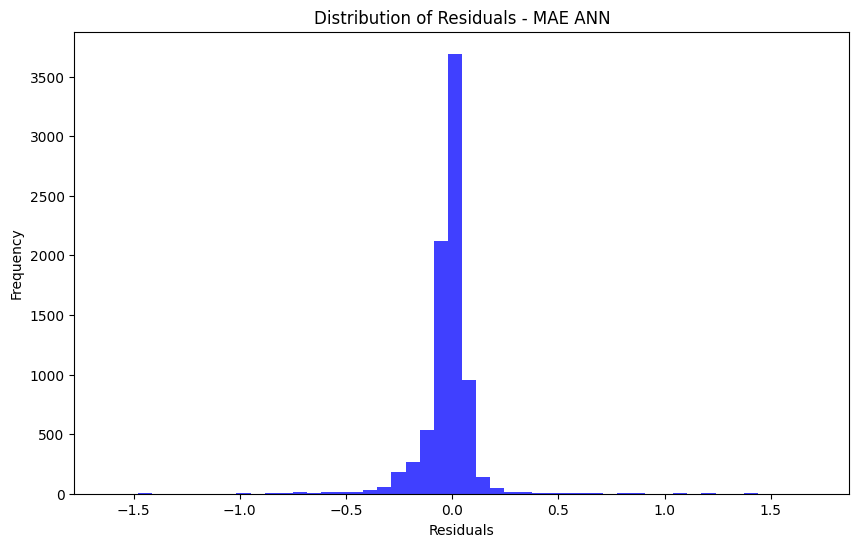

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


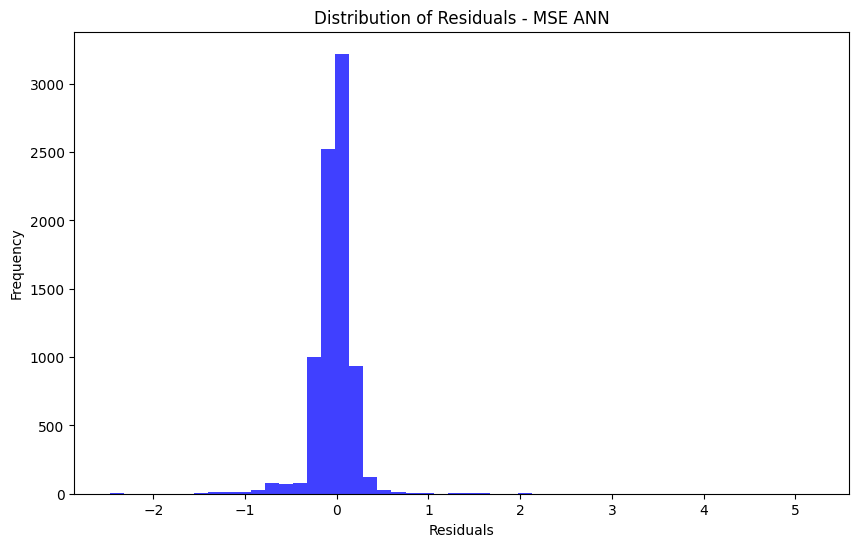

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


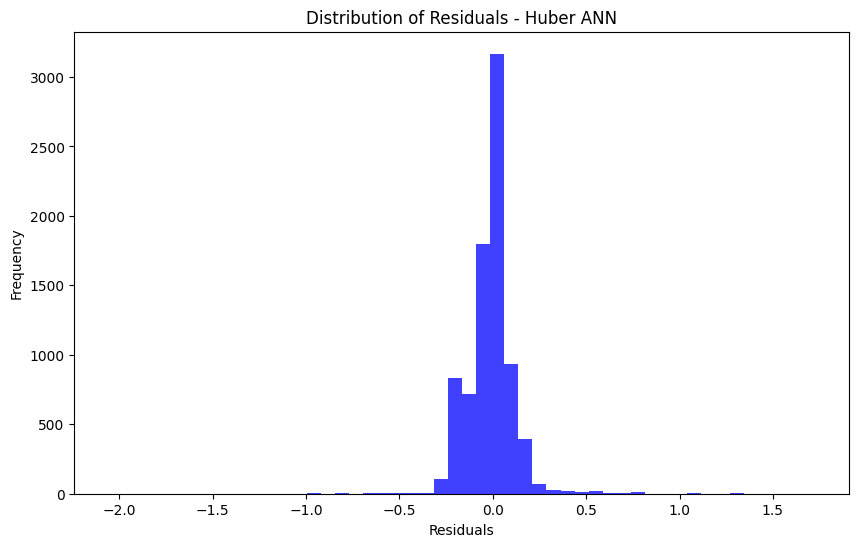

In [21]:
# Plot the distribution of differences between the predicted and true values
def plot_residuals(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.75, color='blue')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Plot residuals for each model
for name, model in models.items():
    plot_residuals(model, X_test, y_test, f'Distribution of Residuals - {name} ANN')
